In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append('../')
from matplotlib import pyplot as plt
import numpy as np

In [3]:
from pyphysim.reference_signals.zadoffchu import calcBaseZC, get_shifted_root_seq
from pyphysim.channels.fading import TdlChannel, TdlChannelProfile, COST259_TUx
from pyphysim.channels.fading_generators import JakesSampleGenerator
from pyphysim.util.conversion import linear2dB

/home/darlan/git_files/pyphysim/pyphysim/util/misc.py:1217: UserWarning: util.misc.count_bits will be slow, since cythonized version was not used
  "util.misc.count_bits will be slow, since cythonized version was not used"


In [4]:
num_prbs = 25;        # Number of PRBs to simulate
Nsc = 12 * num_prbs;  # Number of subcarriers
Nzc = 139;            # Size of the sequence
u1 = 25;               # Root sequence index
u2 = u1#12;               # Root sequence index
u3 = u1#7;               # Root sequence index

# Generate the root sequence
a_u1 = calcBaseZC(Nzc, u1);
a_u2 = calcBaseZC(Nzc, u2);
a_u3 = calcBaseZC(Nzc, u3);

print("Nsc: {0}".format(Nsc))
print("a_u.shape: {0}".format(a_u1.shape))

Nsc: 300
a_u.shape: (139,)


Note that the sequence size Nzc is lower then the number of subcarriers that will have elements of the Zadoff-Chu sequence. That is $Nzc \leq 300/2 = 150$. Therefore, we will append new elements (creating a cyclic sequence).

In [5]:
# Considering a_u currently has 139 elements, we need to append 11 elements to make 150
# TODO: Make this automatically depending on the Nsc and Nzc values
a_u1 = np.hstack([a_u1, a_u1[0:11]])
a_u2 = np.hstack([a_u2, a_u2[0:11]])
a_u3 = np.hstack([a_u3, a_u3[0:11]])

# Create shifted sequences for 3 users

First we arbitrarely choose some cyclic shift indexes and then we call `zadoffchu.getShiftedZF` to get the shifted sequence.

In [6]:
m_u1 = 1 # Cyclic shift index
m_u2 = 4
m_u3 = 7
r1 = get_shifted_root_seq(a_u1, m_u1, denominator=8)
r2 = get_shifted_root_seq(a_u2, m_u2, denominator=8)
r3 = get_shifted_root_seq(a_u3, m_u3, denominator=8)

# Generate channels from users to the BS

Now it's time to transmit the shifted sequences. We need to create the fading channels from two users to some BS.

In [7]:
speedTerminal = 3/3.6        # Speed in m/s
fcDbl = 2.6e9                # Central carrier frequency (in Hz)
timeTTIDbl = 1e-3            # Time of a single TTI
subcarrierBandDbl = 15e3     # Subcarrier bandwidth (in Hz)
numOfSubcarriersPRBInt = 12  # Number of subcarriers in each PRB          

# xxxxxxxxxx Dependent parametersxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
lambdaDbl = 3e8/fcDbl        # Carrier wave length
Fd = speedTerminal / lambdaDbl
Ts = 1./(Nsc * subcarrierBandDbl)

In [9]:
L = 16      # The number of rays for the Jakes model.
# Jakes sample generator for each user.
jakes1 = JakesSampleGenerator(Fd, Ts, L)
jakes2 = JakesSampleGenerator(Fd, Ts, L)
jakes3 = JakesSampleGenerator(Fd, Ts, L)


# Create a TDL channel object for each user
tdlchannel1 = TdlChannel(jakes1, COST259_TUx)
tdlchannel2 = TdlChannel(jakes2, COST259_TUx)
tdlchannel3 = TdlChannel(jakes3, COST259_TUx)

# Compute the fading map for each user
tdlchannel1.generate_impulse_response(1)
tdlchannel2.generate_impulse_response(1)
tdlchannel3.generate_impulse_response(1)
impulse_response1 = tdlchannel1.get_last_impulse_response()
impulse_response2 = tdlchannel2.get_last_impulse_response()
impulse_response3 = tdlchannel3.get_last_impulse_response()

freqResponse1 = impulse_response1.get_freq_response(Nsc)
freqResponse2 = impulse_response2.get_freq_response(Nsc)
freqResponse3 = impulse_response3.get_freq_response(Nsc)

In [11]:
# OPTIONAL: Save the channels for loading in MATLAB
import scipy.io as sio
sio.savemat('channel_freq_resp.mat', {
        'freqResponse1':freqResponse1, 
        'freqResponse2':freqResponse2,
        'freqResponse3':freqResponse3})

Finally we have a channel (freq. response) for each user.

In [12]:
# Each channel is the frequency response in 300 subcarriers
H1 = freqResponse1[:,0]
H2 = freqResponse2[:,0]
H3 = freqResponse3[:,0]

h1 = np.fft.ifft(H1)
h2 = np.fft.ifft(H2)
h3 = np.fft.ifft(H3)

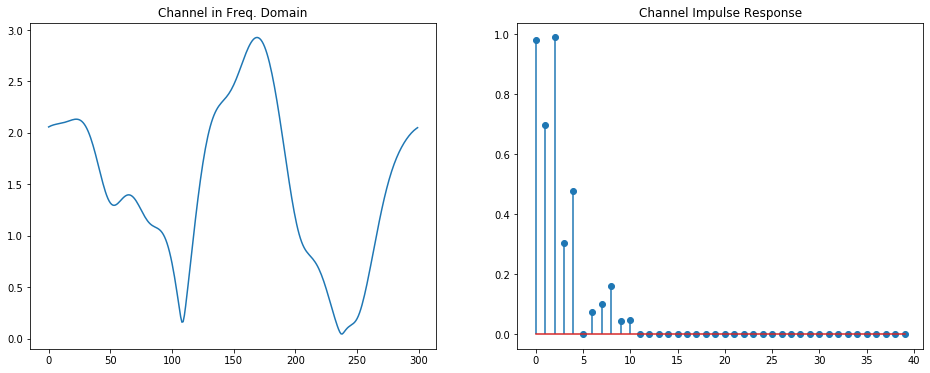

In [25]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(np.abs(H1))
plt.title('Channel in Freq. Domain')
plt.subplot(1,2,2)
plt.stem(np.abs(h1[0:40]), use_line_collection=True)
plt.title('Channel Impulse Response')
plt.show()

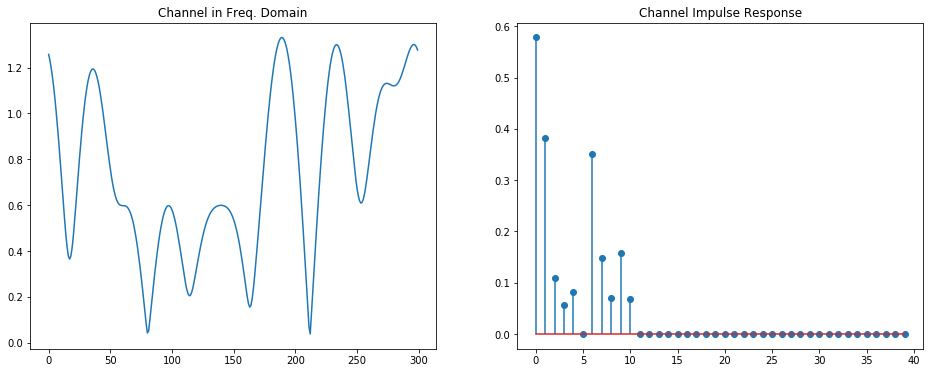

In [26]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(np.abs(H2))
plt.title('Channel in Freq. Domain')
plt.subplot(1,2,2)
plt.stem(np.abs(h2[0:40]), use_line_collection=True)
plt.title('Channel Impulse Response')
plt.show()

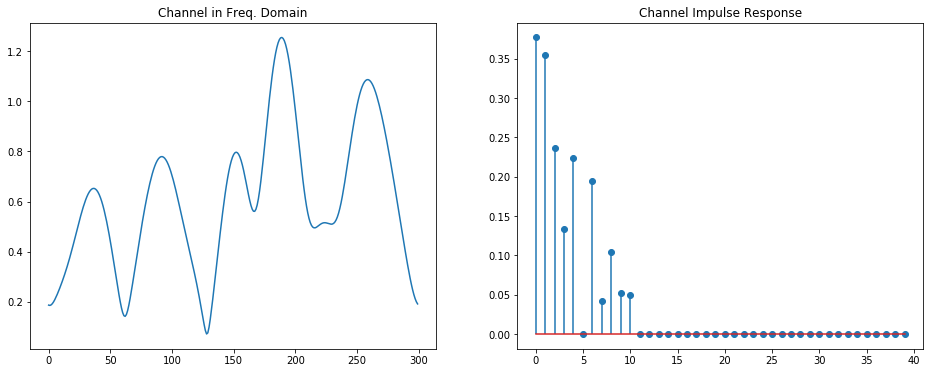

In [27]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(np.abs(H3))
plt.title('Channel in Freq. Domain')
plt.subplot(1,2,2)
plt.stem(np.abs(h3[0:40]), use_line_collection=True)
plt.title('Channel Impulse Response')
plt.show()

## Perform the transmission

First we need to prepare the input data from our shifted Zadoff-Chu sequences.

To makes things clear, let's start transmiting a single sequence and we **won't** include the white noise. Since we use a *comb* to transmit the SRS sequence, we will use Nsc/2 subcarriers from the Nsc subcarriers from a **comb like pattern**.

In [16]:
comb_indexes = np.arange(0, Nsc, 2)

# Note that this is the received signal in the frequency domain
# Here we are not summing users
Y1 = H1[comb_indexes] * r1
Y2 = H2[comb_indexes] * r2
Y3 = H3[comb_indexes] * r3

# Complete transmit signal summing all users
Y = Y1 + Y2 + Y3;

print("Size of Y: {0}".format(Y.size))

Size of Y: 150


According to the paper, 

> ... the received
frequency-domain sequence Y is element-wise multiplied with
the complex conjugate of the expected root sequence X before
the IDFT. This provides in one shot
the concatenated CIRs of all UEs multiplexed on the same root
sequence.

Just for checking let's get the plot of the received signal if **only** users 1 transmits.

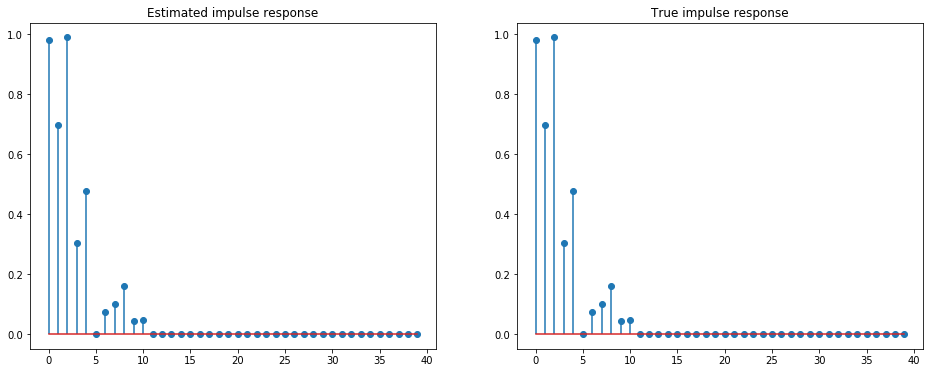

In [28]:
# Just for checking let's get the plot of the received signal if only users 1 transmits.
y1 = np.fft.ifft(np.conj(r1) * Y1)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.stem(np.abs(y1[0:40]), use_line_collection=True)
plt.title("Estimated impulse response")
plt.subplot(1,2,2)
plt.stem(np.abs(h1[0:40]), use_line_collection=True)
plt.title("True impulse response")
plt.show()

And for user 2.

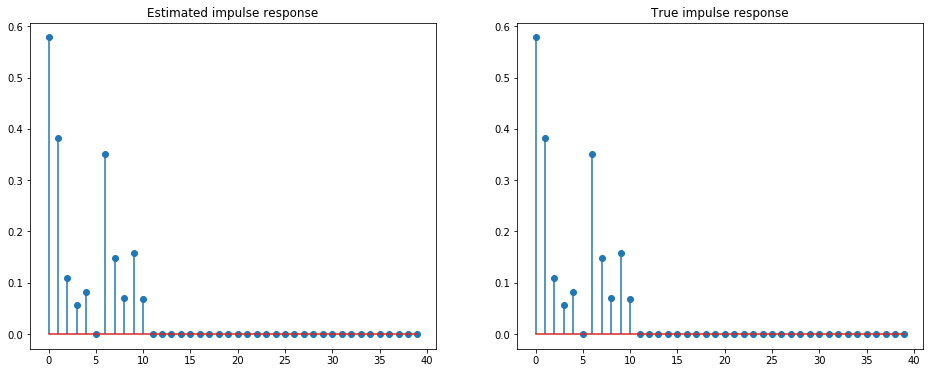

In [29]:
# Just for checking let's get the plot of the received signal if only users 1 transmits.
y2 = np.fft.ifft(np.conj(r2) * Y2)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.stem(np.abs(y2[0:40]), use_line_collection=True)
plt.title("Estimated impulse response")
plt.subplot(1,2,2)
plt.stem(np.abs(h2[0:40]), use_line_collection=True)
plt.title("True impulse response")
plt.show()

And for user 3.

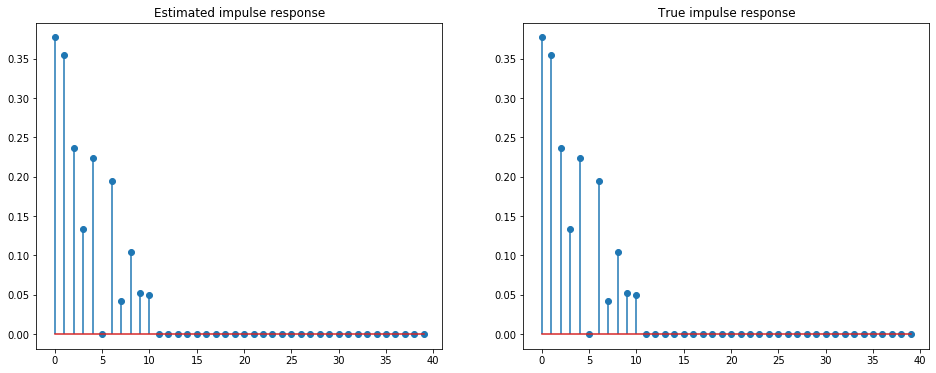

In [30]:
# Just for checking let's get the plot of the received signal if only users 1 transmits.
y3 = np.fft.ifft(np.conj(r3) * Y3)
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.stem(np.abs(y3[0:40]), use_line_collection=True)
plt.title("Estimated impulse response")
plt.subplot(1,2,2)
plt.stem(np.abs(h3[0:40]), use_line_collection=True)
plt.title("True impulse response")
plt.show()

Now let's get the plot of the signal considering that all users transmitted. Notice how the part due to user 1 in the plot is the same channel when only user 1 transmitted. This indicates that Zadoff-chu 0 cross correlation is indeed working.

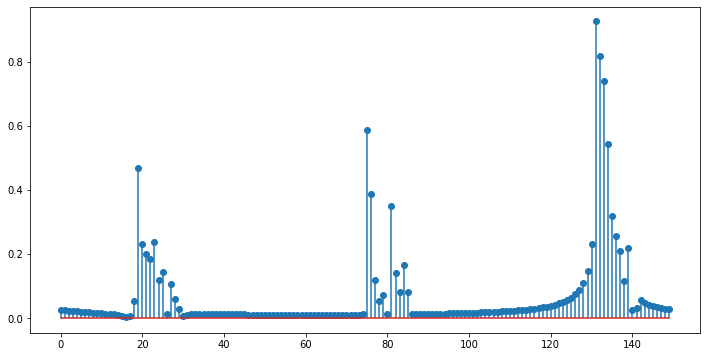

In [31]:
y = np.fft.ifft(np.conj(a_u1) * Y, 150)
plt.figure(figsize=(12,6))
plt.stem(np.abs(y), use_line_collection=True)
plt.show()


# Estimate the channels

Since we get a concatenation of the impulse response of the different users, we need to know for each users we need to know the first and the last sample index corresponding to the particular user's impulse response.

Since we have Nsc subcarriers, from which we will use $Nsc/2$, and we have 3 users, we can imagine that each user can have up to $Nsc/(2*3)$ samples, which for $Nsc=300$ corresponds to 50 subcarriers.


Now let's estimate the channel of the first user.
First let's check again what is the shift used by the first user.

In [21]:
m_u1

1

For an index equal to 1 the starting sample of the first user will be 101 and the ending sample will be 101+50-1=150.

In [50]:
def plot_channel_responses(h, tilde_h):
    """Plot the estimated and true channel responses

    Parameters
    ----------
    h : numpy complex array
        The true channel impulse response
    tilde_h : numpy complex array
        The estimated channel impulse response
    """
    H = np.fft.fft(h)
    tilde_H = np.fft.fft(tilde_h, Nsc)

    plt.figure(figsize=(16,12))

    # Plot estimated impulse response
    ax1 = plt.subplot2grid((3,2), (0,0))
    ax1.stem(np.abs(tilde_h[0:20]), use_line_collection=True)
    plt.xlabel("Time sample")
    plt.ylabel("Amplitude (abs)")
    plt.title("Estimated Impulse Response")
    plt.grid()

    # Plot TRUE impulse response
    ax2 = plt.subplot2grid((3,2), (0,1))
    ax2.stem(np.abs(h[0:20]),linefmt='g', use_line_collection=True)
    plt.xlabel("Time sample")
    plt.ylabel("Amplitude (abs)")
    plt.xlabel("Time sample")
    plt.title("True Impulse Response")
    plt.grid()

    # Plot estimated frequency response (absolute value)
    ax3 = plt.subplot2grid((3,2), (1,0), colspan=2)
    plt.plot(np.abs(tilde_H))
    #plt.xlabel("Subcarrier")
    plt.ylabel("Amplitude (abs)")
    plt.title("Frequency Response (abs)")

    # Plot TRUE frequency response (absolute value)
    #plt.subplot(3,2,4)
    ax3.plot(np.abs(H), 'g')
    plt.grid()
    plt.legend(["Estimated Value", "True Value"], loc='upper left')

    # Plot estimated frequency response (angle)
    ax4 = plt.subplot2grid((3,2), (2,0), colspan=2)
    ax4.plot(np.angle(tilde_H))
    plt.xlabel("Subcarrier")
    plt.ylabel("Angle (phase)")
    plt.title("Frequency Response (phase)")

    # Plot TRUE frequency response (angle)
    ax4.plot(np.angle(H), 'g')
    plt.grid()
    plt.legend(["Estimated Value", "True Value"], loc='upper left')

    # Show the plots
    plt.show()


In [34]:
def plot_normalized_squared_error(H, tilde_H):
    """Plot the normalized squared error (in dB).

    Parameters
    ----------
    H : numpy complex array
        The true channel frequency response
    tilde_H : numpy complex array
        The estimated channel frequency response
    """
    plt.figure(figsize=(12,8))
    error = np.abs(tilde_H - H)**2 / (np.abs(H)**2)
    plt.plot(linear2dB(error))
    plt.title("Normalized Squared Error")
    plt.xlabel("Subcarrier")
    plt.ylabel("Normalized Squared Error (in dB)")
    plt.grid()
    plt.show()

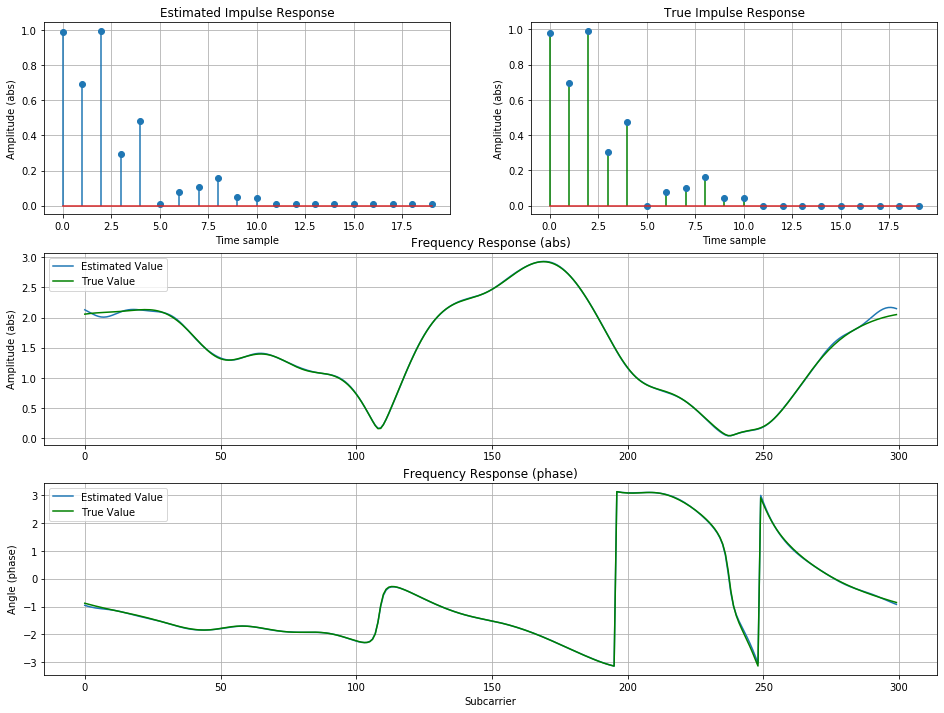

In [51]:
y = np.fft.ifft(np.conj(r1) * Y, 150)
tilde_h1 = y[0:20]
tilde_H1 = np.fft.fft(tilde_h1, Nsc)
tilde_Y1 = tilde_H1[comb_indexes] * r1

plot_channel_responses(h1, tilde_h1)

Now we will compute the squared error in each subcarrier.

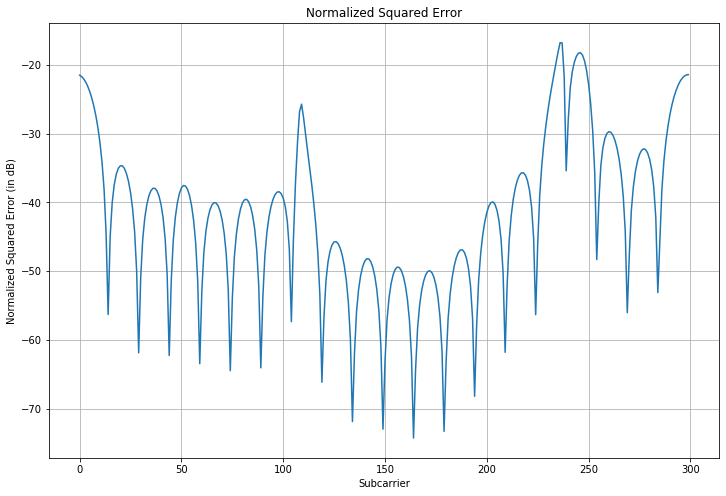

In [52]:
tilde_H1 = np.fft.fft(tilde_h1, Nsc)
plot_normalized_squared_error(H1, tilde_H1)

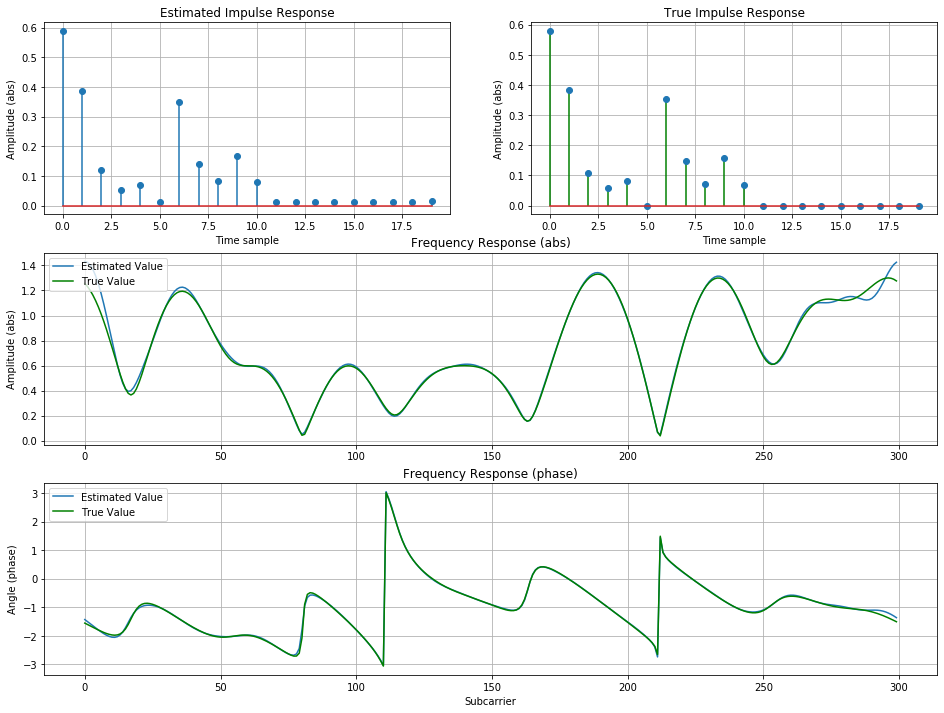

In [53]:
y = np.fft.ifft(np.conj(r2) * (Y), 150)
tilde_h2 = y[0:20]
tilde_H2 = np.fft.fft(tilde_h2, Nsc)
tilde_Y2 = tilde_H2[comb_indexes] * r2

plot_channel_responses(h2, tilde_h2)

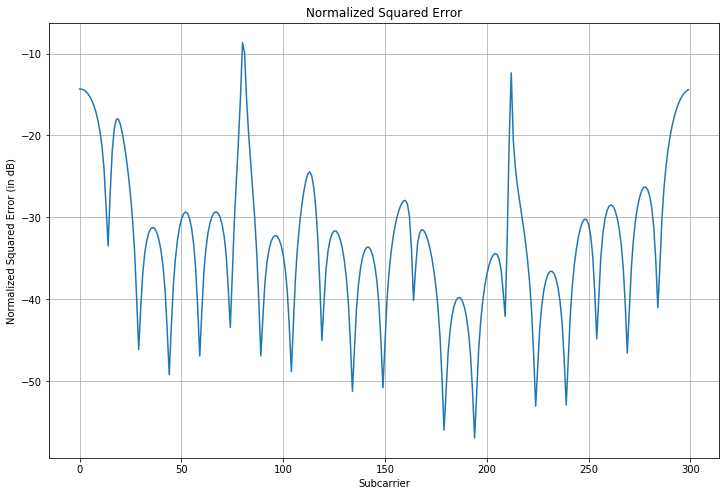

In [54]:
tilde_H2 = np.fft.fft(tilde_h2, Nsc)
plot_normalized_squared_error(H2, tilde_H2)

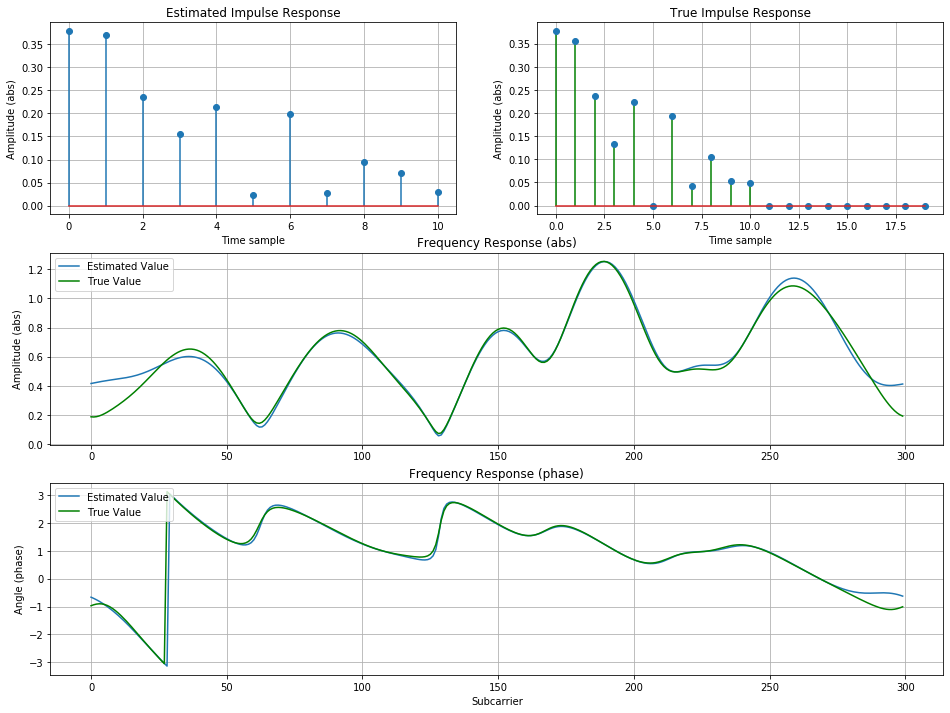

In [55]:
y = np.fft.ifft(np.conj(r3) * (Y), 150)
tilde_h3 = y[0:11]
tilde_H3 = np.fft.fft(tilde_h3, Nsc)
tilde_Y3 = tilde_H3[comb_indexes] * r3

plot_channel_responses(h3, tilde_h3)

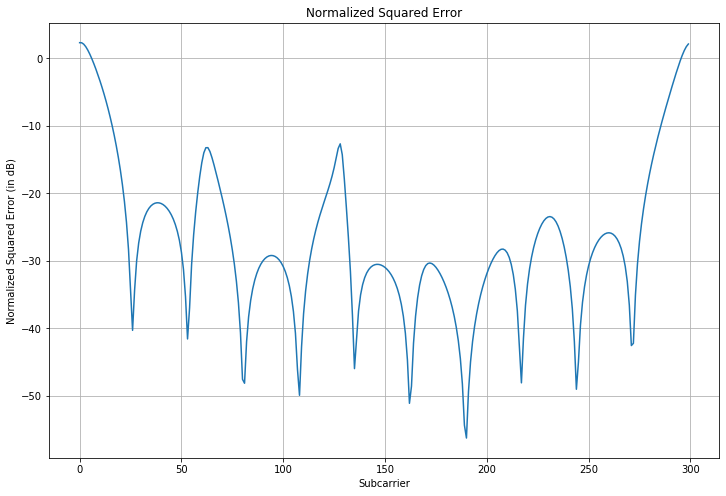

In [56]:
tilde_H3 = np.fft.fft(tilde_h3, Nsc)
plot_normalized_squared_error(H3, tilde_H3)

## Estimated the channels from corrupted (white noise) signal

Now we will add some white noise to Y

In [57]:
# Add white noise
noise_var = 1e-2
Y_noised = Y + np.sqrt(noise_var/2.) * (np.random.randn(Nsc//2) + 1j * np.random.randn(Nsc//2))

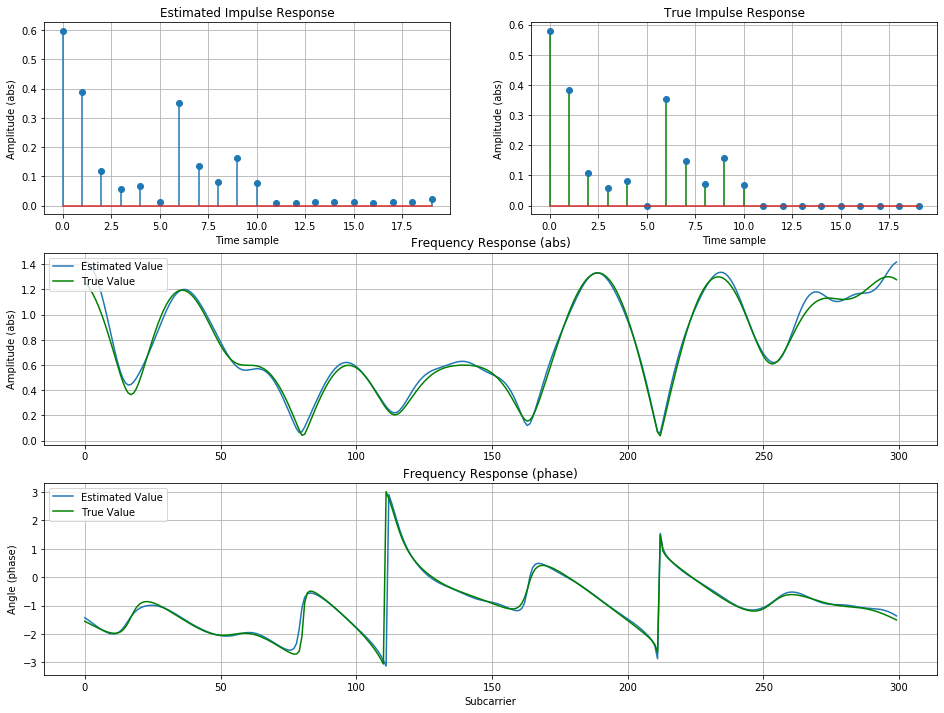

In [58]:
y_noised = np.fft.ifft(np.conj(r2) * (Y_noised), 150)
tilde_h2_noised = y_noised[0:20]

plot_channel_responses(h2, tilde_h2_noised)

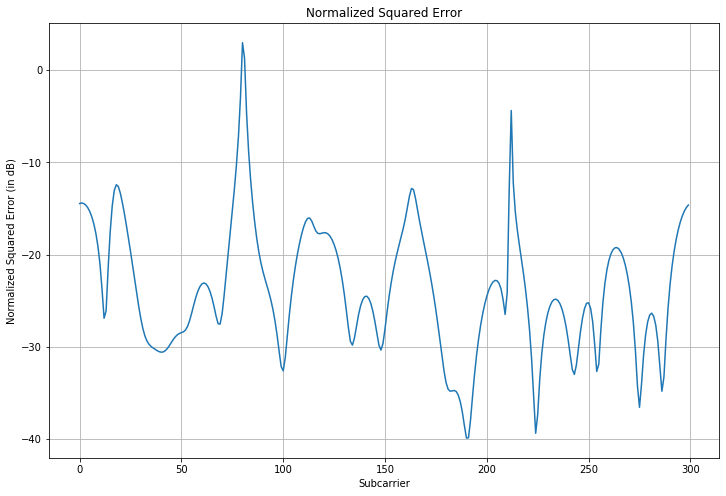

In [59]:
tilde_H2_noised = np.fft.fft(tilde_h2_noised, Nsc)
plot_normalized_squared_error(H2, tilde_H2_noised)